# Importing Libraries and Overview

In [1]:
# Data Manipulation, Linear Algebra
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve

from sklearn import tree, linear_model, ensemble
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [2]:
train_data = pd.read_csv("adult_data.csv")
test_data = pd.read_csv("adult_test.csv")

In [3]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (32561, 15)
Test Data Shape: (16281, 15)


## Striping Spaces from Column Names

In [4]:
cols = []
for col in train_data.columns:
    cols.append(col.strip())

train_data = train_data.set_axis(cols, axis=1)
test_data = test_data.set_axis(cols, axis=1)

test_data["salary"] = test_data["salary"].apply(lambda x: x.strip("."))

## Striping Spaces from Data

In [5]:
obj_cols = train_data.select_dtypes(include=[np.object]).columns

for col in obj_cols:
    train_data[col] = train_data[col].apply(lambda x: x.strip())
    test_data[col] = test_data[col].apply(lambda x: x.strip())

## Viewing Data Samples

In [6]:
train_data.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
25810,47,Private,99911,12th,8,Married-spouse-absent,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States,<=50K
10918,20,Private,236592,12th,8,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,35,Italy,<=50K
29475,31,Private,62165,HS-grad,9,Never-married,Other-service,Own-child,Black,Male,0,0,40,United-States,<=50K
27166,46,Self-emp-inc,125892,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,>50K
18581,19,Private,25429,12th,8,Never-married,Other-service,Own-child,White,Female,0,0,20,United-States,<=50K


In [7]:
test_data.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
11066,50,Private,180439,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,33,United-States,<=50K
10771,68,Local-gov,212932,10th,6,Married-civ-spouse,Other-service,Husband,Black,Male,0,0,20,United-States,<=50K
10186,22,Private,150336,Some-college,10,Divorced,Tech-support,Other-relative,White,Female,0,0,40,United-States,<=50K
5616,59,Private,750972,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
1493,27,Private,263728,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,3137,0,50,United-States,<=50K


# Data Cleaning

## Dropping "race" and "education" feature

In [8]:
train_data.drop(["race", "education"], axis=1, inplace=True)
test_data.drop(["race", "education"], axis=1, inplace=True)

## Label Encode "sex"

In [9]:
le = LabelEncoder()

train_data["sex"] = le.fit_transform(train_data["sex"])
test_data["sex"] = le.fit_transform(test_data["sex"])

## Modifying Data in "native-country" Column
### 0 if United States and 1 if other

In [10]:
train_data["native-country"] = train_data["native-country"].map(lambda x: 0 if x=="United-States" else 1)
test_data["native-country"] = test_data["native-country"].map(lambda x: 0 if x=="United-States" else 1)

# EDA

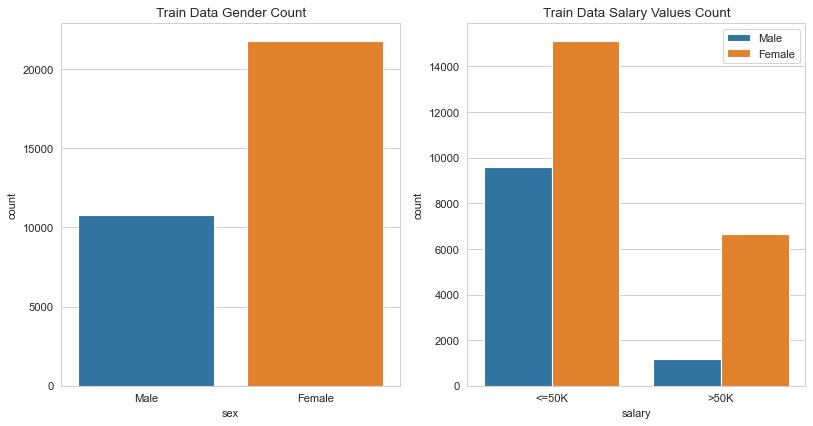

In [97]:
plt.figure(dpi=80, figsize=(12, 6))

plt.subplot(121)
sns.countplot(x="sex", data=train_data)
plt.title("Train Data Gender Count")
plt.xticks([0, 1], ["Male", "Female"])

plt.subplot(122)
sns.countplot(x="salary", hue="sex", data=train_data)
plt.title("Train Data Salary Values Count")
plt.legend(["Male", "Female"])

plt.show()

#### Most of the People have less than 50K salary
#### Most of the People with more than 50K salary are women

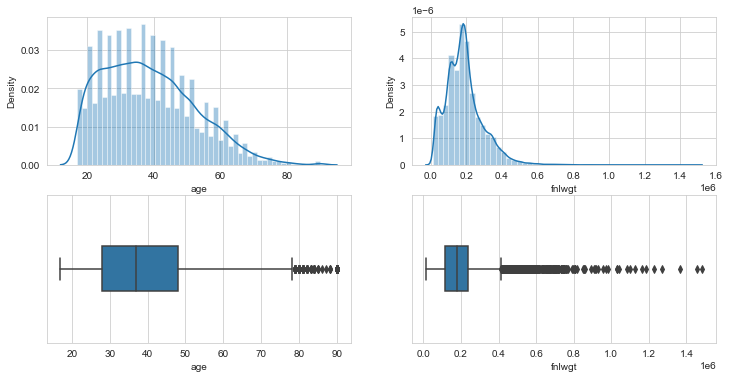

In [102]:
plt.figure(figsize=(12, 6))

plt.subplot(221)
sns.distplot(train_data.age)

plt.subplot(222)
sns.distplot(train_data.fnlwgt)

plt.subplot(223)
sns.boxplot(train_data.age, width=0.3)

plt.subplot(224)
sns.boxplot(train_data.fnlwgt, width=0.3)
plt.show()



#### The data for age and final weight is right skewed

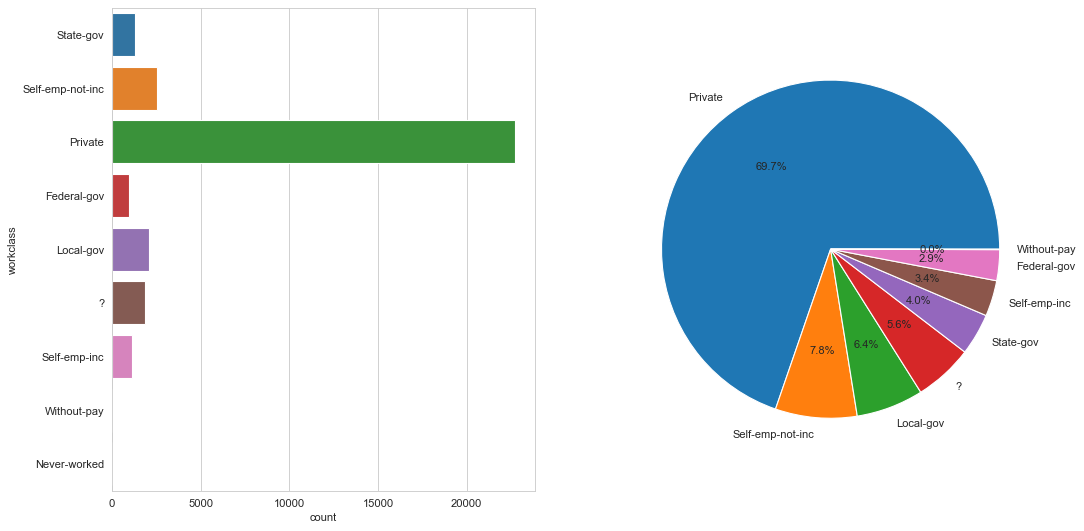

In [114]:
plt.figure(dpi=80, figsize=(15, 8))

plt.subplot(121)
sns.countplot(y=train_data.workclass)

plt.subplot(122)
plt.pie(train_data.workclass.value_counts()[:-1], autopct='%.1f%%', labels=train_data.workclass.value_counts().index[:-1])

plt.show()

In [123]:
train_data.loc[train_data.salary == ">50K"].groupby("workclass")["salary"].value_counts()

workclass         salary
?                 >50K       191
Federal-gov       >50K       371
Local-gov         >50K       617
Private           >50K      4963
Self-emp-inc      >50K       622
Self-emp-not-inc  >50K       724
State-gov         >50K       353
Name: salary, dtype: int64

#### Most of the people that have higher than 50K salary work in Privare Sector

In [124]:
train_data.loc[train_data.salary != ">50K"].groupby("workclass")["salary"].value_counts()

workclass         salary
?                 <=50K      1645
Federal-gov       <=50K       589
Local-gov         <=50K      1476
Never-worked      <=50K         7
Private           <=50K     17733
Self-emp-inc      <=50K       494
Self-emp-not-inc  <=50K      1817
State-gov         <=50K       945
Without-pay       <=50K        14
Name: salary, dtype: int64

#### Most of the people that have salary lower than 50K also work in Privare Sector

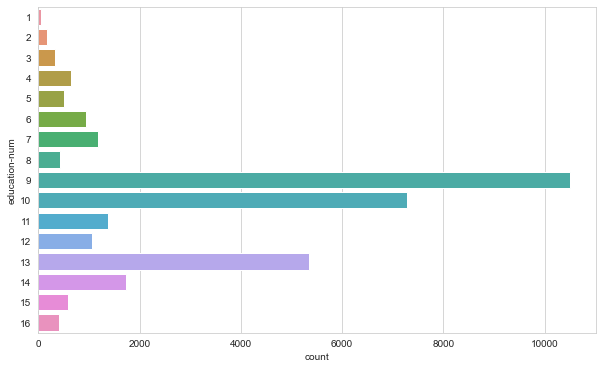

In [127]:
plt.figure(figsize=(10, 6))
sns.countplot(y="education-num", data=train_data)
plt.show()

#### Most of the people have 9, 10 and 13 Qualifications

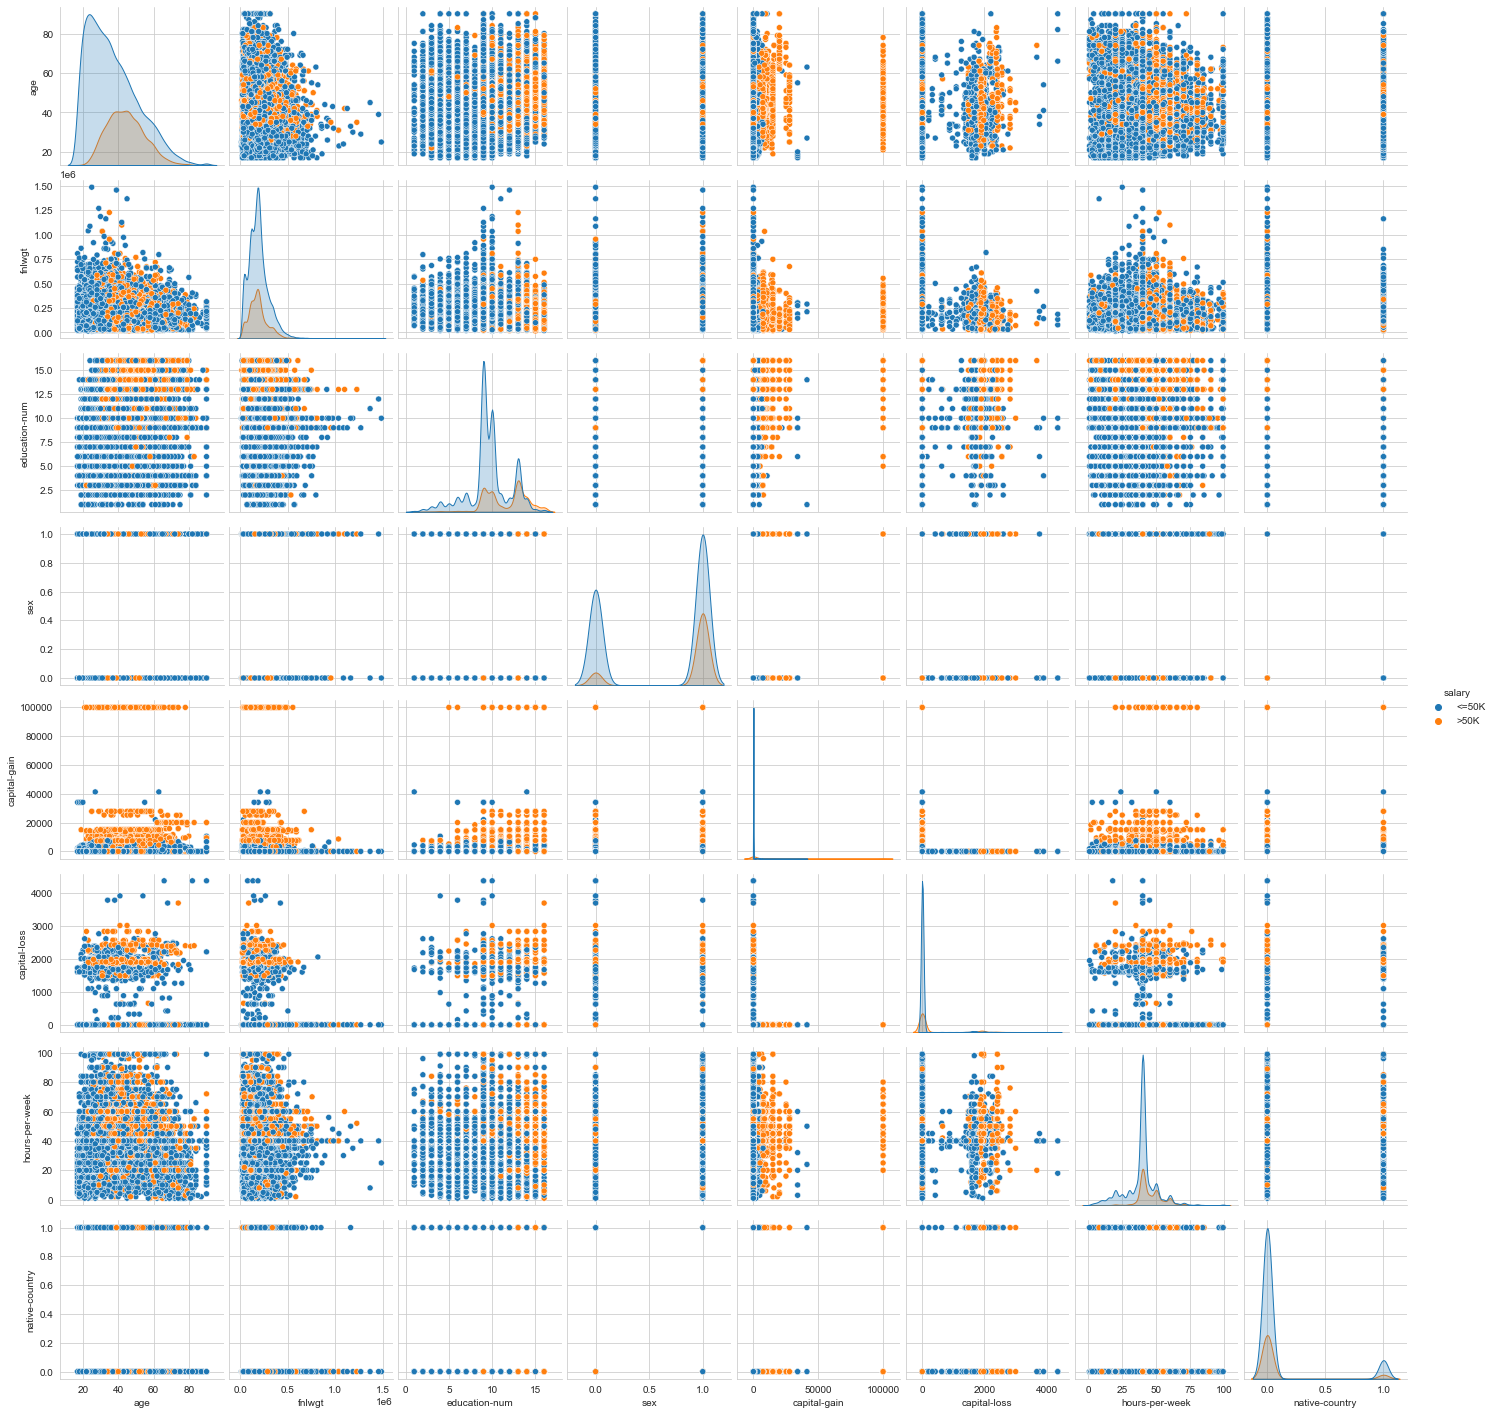

In [128]:
sns.pairplot(train_data, hue="salary")
plt.show()

# Preparing Data

## Seperating Dependent Variable

In [11]:
X_train = train_data.drop("salary", axis=1)
y_train = train_data["salary"]

X_test = test_data.drop("salary", axis=1)
y_test = test_data["salary"]

## Feature Scaling Numerical Columns

In [12]:
X_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,1,2174,0,40,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,1,0,0,13,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,1,0,0,40,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,1,0,0,40,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,0,0,0,40,1


In [13]:
num_cols = list(X_train.select_dtypes(include=[np.number]).columns)
num_cols.remove("sex")
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

In [14]:
scaler = StandardScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
scaled_test = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

X_train.drop(num_cols, axis=1, inplace=True)
X_test.drop(num_cols, axis=1, inplace=True)

In [15]:
X_train = pd.concat([X_train, scaled_train], axis=1)
X_test = pd.concat([X_test, scaled_test], axis=1)

In [16]:
X_train.head()

,workclass,marital-status,occupation,relationship,sex,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country
0,State-gov,Never-married,Adm-clerical,Not-in-family,1,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,-0.340954
1,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,-0.340954
2,Private,Divorced,Handlers-cleaners,Not-in-family,1,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,-0.340954
3,Private,Married-civ-spouse,Handlers-cleaners,Husband,1,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,-0.340954
4,Private,Married-civ-spouse,Prof-specialty,Wife,0,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,2.932948


## OneHotEncoding Categorcal Variables

In [17]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [18]:
X_train.head()

,sex,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,native-country,workclass_?,workclass_Federal-gov,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,1,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,-0.340954,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,-0.340954,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,-0.340954,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,-0.340954,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,2.932948,0,0,...,0,0,0,0,0,0,0,0,0,1


# Modeling

## Dataframe to store all the accuracy scores for Comparison and Analysis

In [19]:
MLA_compare = pd.DataFrame()

row_index = 0

def MLA_testing(MLA, X_train, X_test, y_train, y_test):  
    global row_index
    
    # Training The Model
    MLA.fit(X_train, y_train)

    # KFold Accuracies on Training Data
    kfold_accuracy = cross_val_score(estimator = MLA, X = X_train, y = y_train, cv = 10, n_jobs=-1)
    print("K-Fold Accuracies:\n", kfold_accuracy, "\n")
    
    # Prediction on Testing Data
    y_pred = cross_val_predict(estimator = MLA, X = X_test, y = y_test, cv = 10, n_jobs=-1)
    
    # Accuracy for y_test and y_pred
    classifier_accuracy_score = accuracy_score(y_test, y_pred)
    print("Accuracy Score:\n", classifier_accuracy_score, "\n")
    
    # Confusion Matrix
    conf_mtx = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_mtx, "\n")
    
    # Classification Report
    class_rep = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_rep, "\n")
    
    # Saving Data in Dataframe
    MLA_name = MLA.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score
    MLA_compare.loc[row_index, 'K-Fold Accuracy'] = kfold_accuracy.mean()

    print(MLA_name, "Done")
    
    row_index+=1

## RandomForestClassifier

In [20]:
rf_clf = ensemble.RandomForestClassifier()

MLA_testing(rf_clf, X_train.values, X_test.values, y_train.values, y_test.values)

K-Fold Accuracies:
 [0.84587043 0.86578624 0.85042998 0.8544226  0.85933661 0.8519656
 0.85995086 0.86148649 0.86517199 0.85780098] 

Accuracy Score:
 0.8572569252502917 

Confusion Matrix:
 [[11587   848]
 [ 1476  2370]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     12435
        >50K       0.74      0.62      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.81      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281
 

RandomForestClassifier Done


### Viewing Top 10 Important Features

In [35]:
# Feature Importance Score DataFrame
feature_imp = pd.DataFrame()

# Getting the Feature Names and Their Importance Scores
feature_imp["Features"] = X_train.columns
feature_imp["Features Importance Score"] = rf_clf.feature_importances_

# Sorting
feature_imp = feature_imp.sort_values(by="Features Importance Score", ascending=False).reset_index(drop=True)[:15]
feature_imp

,Features,Features Importance Score
0,fnlwgt,0.178025
1,age,0.152523
2,education-num,0.116270
3,capital-gain,0.104958
4,hours-per-week,0.086420
5,marital-status_Married-civ-spouse,0.071514
6,relationship_Husband,0.045609
7,capital-loss,0.033877
8,marital-status_Never-married,0.026643
9,occupation_Exec-managerial,0.019364


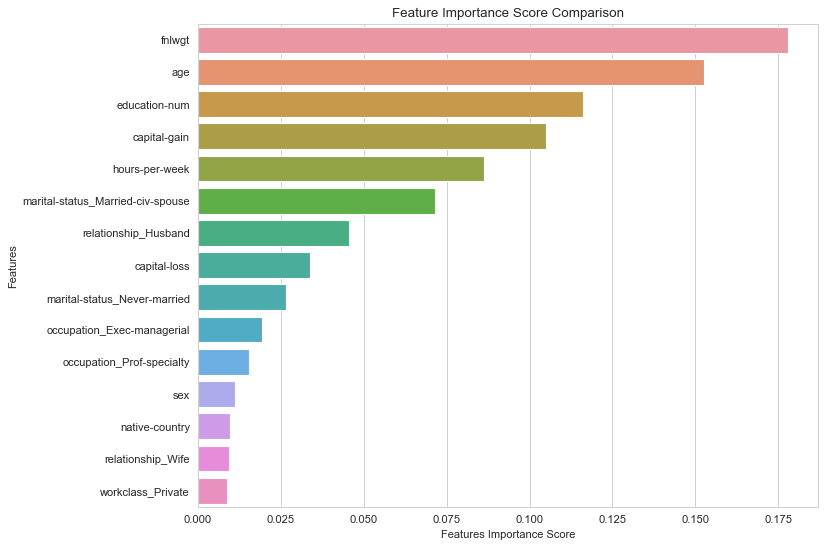

In [38]:
plt.figure(figsize=(10, 8), dpi=80)
sns.barplot(x="Features Importance Score", y="Features", data=feature_imp)
plt.title("Feature Importance Score Comparison")
plt.show()

## GradientBoostingClassifier

In [21]:
gb_clf = ensemble.GradientBoostingClassifier()

MLA_testing(gb_clf, X_train, X_test, y_train, y_test)

K-Fold Accuracies:
 [0.85968683 0.86670762 0.86855037 0.85718673 0.86701474 0.86640049
 0.86547912 0.87469287 0.86793612 0.86578624] 

Accuracy Score:
 0.8688041275105952 

Confusion Matrix:
 [[11837   598]
 [ 1538  2308]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92     12435
        >50K       0.79      0.60      0.68      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.78      0.80     16281
weighted avg       0.86      0.87      0.86     16281
 

GradientBoostingClassifier Done


## LogisticRegression

In [22]:
lr_clf = linear_model.LogisticRegression()

MLA_testing(lr_clf, X_train, X_test, y_train, y_test)

K-Fold Accuracies:
 [0.84986184 0.85012285 0.8544226  0.83998771 0.85687961 0.8507371
 0.84889435 0.85902948 0.85534398 0.84981572] 

Accuracy Score:
 0.85148332412014 

Confusion Matrix:
 [[11596   839]
 [ 1579  2267]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     12435
        >50K       0.73      0.59      0.65      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg       0.84      0.85      0.85     16281
 

LogisticRegression Done


## SGDClassifier

In [23]:
sgf_clf = linear_model.SGDClassifier(loss="log")

MLA_testing(sgf_clf, X_train, X_test, y_train, y_test)

K-Fold Accuracies:
 [0.84709856 0.8458231  0.8531941  0.84121622 0.85380835 0.85135135
 0.84613022 0.85718673 0.8507371  0.84920147] 

Accuracy Score:
 0.8473066764940729 

Confusion Matrix:
 [[11495   940]
 [ 1546  2300]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     12435
        >50K       0.71      0.60      0.65      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.76      0.78     16281
weighted avg       0.84      0.85      0.84     16281
 

SGDClassifier Done


## DecisionTreeClassifier

In [24]:
dt_clf = tree.DecisionTreeClassifier()

MLA_testing(dt_clf, X_train, X_test, y_train, y_test)

K-Fold Accuracies:
 [0.81148296 0.81480344 0.81418919 0.81357494 0.82063882 0.81787469
 0.8215602  0.82248157 0.83138821 0.81111794] 

Accuracy Score:
 0.8108838523432221 

Confusion Matrix:
 [[10812  1623]
 [ 1456  2390]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88     12435
        >50K       0.60      0.62      0.61      3846

    accuracy                           0.81     16281
   macro avg       0.74      0.75      0.74     16281
weighted avg       0.81      0.81      0.81     16281
 

DecisionTreeClassifier Done


## XGBoostClassifier

In [25]:
xgb_clf = XGBClassifier(eval_metric="logloss")

MLA_testing(xgb_clf, X_train, X_test, y_train, y_test)

K-Fold Accuracies:
 [0.86644151 0.87192875 0.87807125 0.86056511 0.86578624 0.87039312
 0.86793612 0.872543   0.87346437 0.87070025] 

Accuracy Score:
 0.8628462625145875 

Confusion Matrix:
 [[11612   823]
 [ 1410  2436]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91     12435
        >50K       0.75      0.63      0.69      3846

    accuracy                           0.86     16281
   macro avg       0.82      0.78      0.80     16281
weighted avg       0.86      0.86      0.86     16281
 

XGBClassifier Done


## CatBoostClassifier

In [26]:
cb_clf = CatBoostClassifier(silent=True)

MLA_testing(cb_clf, X_train, X_test, y_train, y_test)

K-Fold Accuracies:
 [0.86981885 0.87100737 0.87653563 0.86762899 0.87100737 0.8713145
 0.87192875 0.88206388 0.87929975 0.87070025] 

Accuracy Score:
 0.8695411829740188 

Confusion Matrix:
 [[11721   714]
 [ 1410  2436]] 

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92     12435
        >50K       0.77      0.63      0.70      3846

    accuracy                           0.87     16281
   macro avg       0.83      0.79      0.81     16281
weighted avg       0.86      0.87      0.86     16281
 

CatBoostClassifier Done


# Comparing Models

In [28]:
MLA_compare = MLA_compare.sort_values(by="K-Fold Accuracy", ascending=False).reset_index(drop=True)
MLA_compare

,MLA Name,Accuracy Score,K-Fold Accuracy
0,CatBoostClassifier,0.869541,0.873131
1,XGBClassifier,0.862846,0.869783
2,GradientBoostingClassifier,0.868804,0.865944
3,RandomForestClassifier,0.857257,0.857222
4,LogisticRegression,0.851483,0.851510
5,SGDClassifier,0.847307,0.849575
6,DecisionTreeClassifier,0.810884,0.817911
